In [2]:
import numpy as np
import torch as th
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os, glob, tqdm
import torchvision.transforms.functional as F
from torchvision.io import read_image
from pathlib import Path
import cv2
from torchvision.utils import make_grid

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    fig.set_size_inches(18, 6)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
def face_segment(segment_part, img):
    
    if isinstance(img, Image.Image):
        face_segment_anno = np.array(img)
    else:
        face_segment_anno = img
        
    bg = (face_segment_anno == 0)
    skin = (face_segment_anno == 1)
    l_brow = (face_segment_anno == 2)
    r_brow = (face_segment_anno == 3)
    l_eye = (face_segment_anno == 4)
    r_eye = (face_segment_anno == 5)
    eye_g = (face_segment_anno == 6)
    l_ear = (face_segment_anno == 7)
    r_ear = (face_segment_anno == 8)
    ear_r = (face_segment_anno == 9)
    nose = (face_segment_anno == 10)
    mouth = (face_segment_anno == 11)
    u_lip = (face_segment_anno == 12)
    l_lip = (face_segment_anno == 13)
    neck = (face_segment_anno == 14)
    neck_l = (face_segment_anno == 15)
    cloth = (face_segment_anno == 16)
    hair = (face_segment_anno == 17)
    hat = (face_segment_anno == 18)
    face = np.logical_or.reduce((skin, l_brow, r_brow, l_eye, r_eye, eye_g, l_ear, r_ear, ear_r, nose, mouth, u_lip, l_lip))

    if segment_part == 'faceseg_face':
        seg_m = face
    elif segment_part == 'faceseg_head':
        seg_m = (face | neck | hair)
    elif segment_part == 'faceseg_nohead':
        seg_m = ~(face | neck | hair)
    elif segment_part == 'faceseg_face&hair':
        seg_m = ~bg
    elif segment_part == 'faceseg_bg_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) 
    elif segment_part == 'faceseg_bg&ears_noface&nohair':
        seg_m = (bg | hat | neck | neck_l | cloth) | (l_ear | r_ear | ear_r)
    elif segment_part == 'faceseg_bg':
        seg_m = bg
    elif segment_part == 'faceseg_bg&noface':
        seg_m = (bg | hair | hat | neck | neck_l | cloth)
    elif segment_part == 'faceseg_hair':
        seg_m = hair
    elif segment_part == 'faceseg_faceskin':
        seg_m = skin
    elif segment_part == 'faceseg_faceskin&nose':
        seg_m = (skin | nose)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye)
    elif segment_part == 'faceseg_faceskin&nose&mouth&eyebrows&eyes&glasses':
        seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow | l_eye | r_eye | eye_g)
        # seg_m = (skin | nose | mouth | u_lip | l_lip | l_brow | r_brow)
    elif segment_part == 'faceseg_face_noglasses':
        seg_m = (~eye_g & face)
    elif segment_part == 'faceseg_face_noglasses_noeyes':
        seg_m = (~(l_eye | r_eye) & ~eye_g & face)
    elif segment_part == 'faceseg_eyes&glasses':
        seg_m = (l_eye | r_eye | eye_g)
    elif segment_part == 'glasses':
        seg_m = eye_g
    elif segment_part == 'faceseg_eyes':
        seg_m = (l_eye | r_eye)
    elif segment_part == 'faceseg_eyebrows':
        seg_m = (l_brow | r_brow)
    elif segment_part == 'faceseg_mouth':
        seg_m = mouth
    # elif (segment_part == 'sobel_bg_mask') or (segment_part == 'laplacian_bg_mask') or (segment_part == 'sobel_bin_bg_mask'):
    elif segment_part in ['sobel_bg_mask', 'laplacian_bg_mask', 'sobel_bin_bg_mask']:
        seg_m = ~(face | neck | hair)
    elif segment_part in ['canny_edge_bg_mask']:
        seg_m = ~(face | neck | hair) | (l_ear | r_ear)
    else: raise NotImplementedError(f"Segment part: {segment_part} is not found!")
    
    out = seg_m
    return out

def get_shadow_diff(img1, img2, c_type='L', signed=False):
    # Compute Shadow Difference
    img1 = np.array(img1.convert(c_type)) / 255.0
    img2 = np.array(img2.convert(c_type)) / 255.0
    if signed:
        shadow_diff = img2 - img1
    else:
        shadow_diff = np.abs(img2 - img1)
    return shadow_diff

def create_image_grid(images, n_rows=1, text_labels=[]):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)

    # Add text labels to the grid
    img_height, img_width = images[0].shape[:2]
    for i, text_label in enumerate(text_labels):
        # plt.text((i % n_cols) * img_width, (i // n_cols) * img_height, text_label, color='red', fontsize=12)
        if isinstance(text_label, str):
            plt.text((i % n_cols) * img_width, -2, text_label, color='red', fontsize=20)
        else:
            plt.text((i % n_cols) * img_width, -2, f'{float(text_label):.5f}', color='red', fontsize=20)

    return grid_image


[['42022.jpg' 8.481700287326827]
 ['9629.jpg' 8.46526838144226]
 ['16177.jpg' 8.30883471018521]
 ['24750.jpg' 7.811802972893543]
 ['34765.jpg' 7.668337381685788]]
[['31402.jpg' -4.858566149922109]
 ['3819.jpg' -4.912521948825733]
 ['45182.jpg' -4.940842814153032]
 ['26571.jpg' -4.951273075917054]
 ['2773.jpg' -4.989461058405101]]
Min-Max c-values:  -4.989461058405101 8.481700287326827


<Figure size 1440x1440 with 0 Axes>

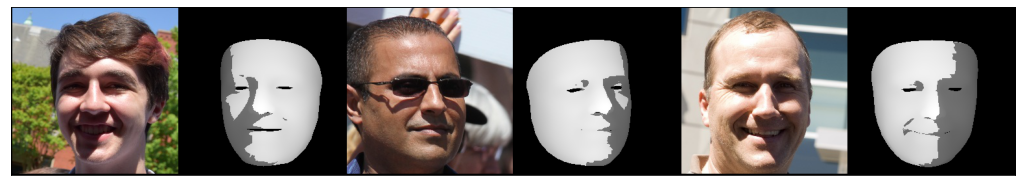

<Figure size 1440x1440 with 0 Axes>

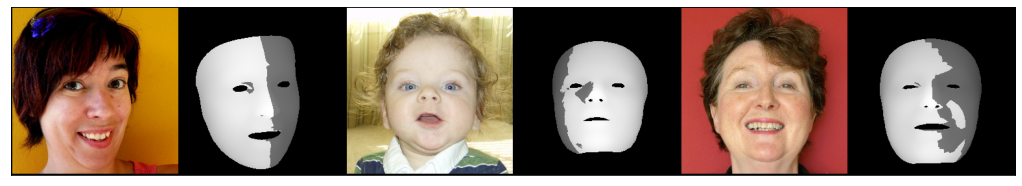

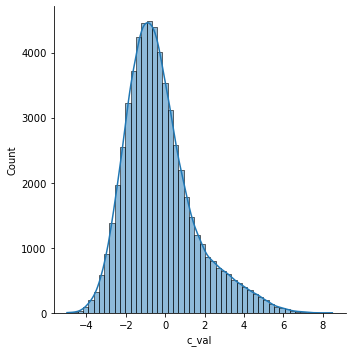

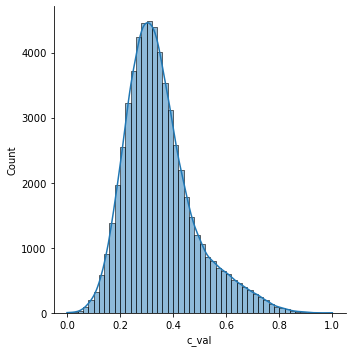

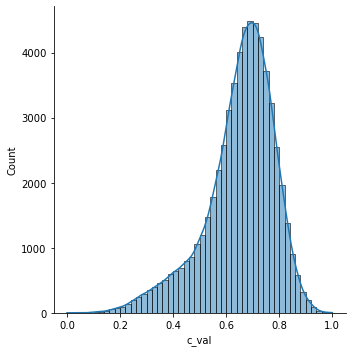

In [3]:
data_path = '/data/mint/DPM_Dataset/ffhq_256_with_anno/'
set_ = 'train'
c_p = f'{data_path}/params/{set_}/ffhq-{set_}-shadow-anno.txt'
img_p = f'{data_path}/ffhq_256/{set_}/'
ray_p = f'{data_path}/shadow_masks/{set_}/'
shadow_diff_path = f'{data_path}/shadow_diff_with_weight_simplified/{set_}'

c = pd.read_csv(c_p, sep=' ', header=None, names=['image_name', 'c_val'])
c_sorted = c.sort_values(by=['c_val'], ascending=False)
print(c_sorted.head(5).values)
print(c_sorted.tail(5).values)
print("Min-Max c-values: ", c_sorted['c_val'].min(), c_sorted['c_val'].max())

n = 3
img_top_n = [read_image(f'{img_p}/{c_sorted.iloc[i, 0]}') for i in range(n)]
ray_top_n = [read_image(f"{ray_p}/{c_sorted.iloc[i, 0].replace('.jpg', '.png')}") for i in range(n)]
img_bot_n = [read_image(f'{img_p}/{c_sorted.iloc[i, 0]}') for i in range(-1, -n-1, -1)]
ray_bot_n = [read_image(f"{ray_p}/{c_sorted.iloc[i, 0].replace('.jpg', '.png')}") for i in range(-1, -n-1, -1)]

# Combined n list into 1 list
vis_top_n = sum([[img_top_n[i], ray_top_n[i]] for i in range(n)], [])
vis_bot_n = sum([[img_bot_n[i], ray_bot_n[i]] for i in range(n)], [])

plt.figure(figsize=(20, 20))
show(make_grid(vis_top_n))
plt.figure(figsize=(20, 20))
show(make_grid(vis_bot_n))

import seaborn as sns
sns.displot(c_sorted['c_val'], kde=True, bins=50)

c_sorted_norm = c_sorted.copy()
c_sorted_norm['c_val'] = (c_sorted['c_val'] - c_sorted['c_val'].min()) / (c_sorted['c_val'].max() - c_sorted['c_val'].min())
sns.displot(c_sorted_norm['c_val'], kde=True, bins=50)
sns.displot(1 - c_sorted_norm['c_val'], kde=True, bins=50)

Mean:  0.34956119320024237
Std:  0.1314823457058355
[#] Proc: 0.15 <= c_val <= 0.15
Length of c_vis:  6
0 0
[0]


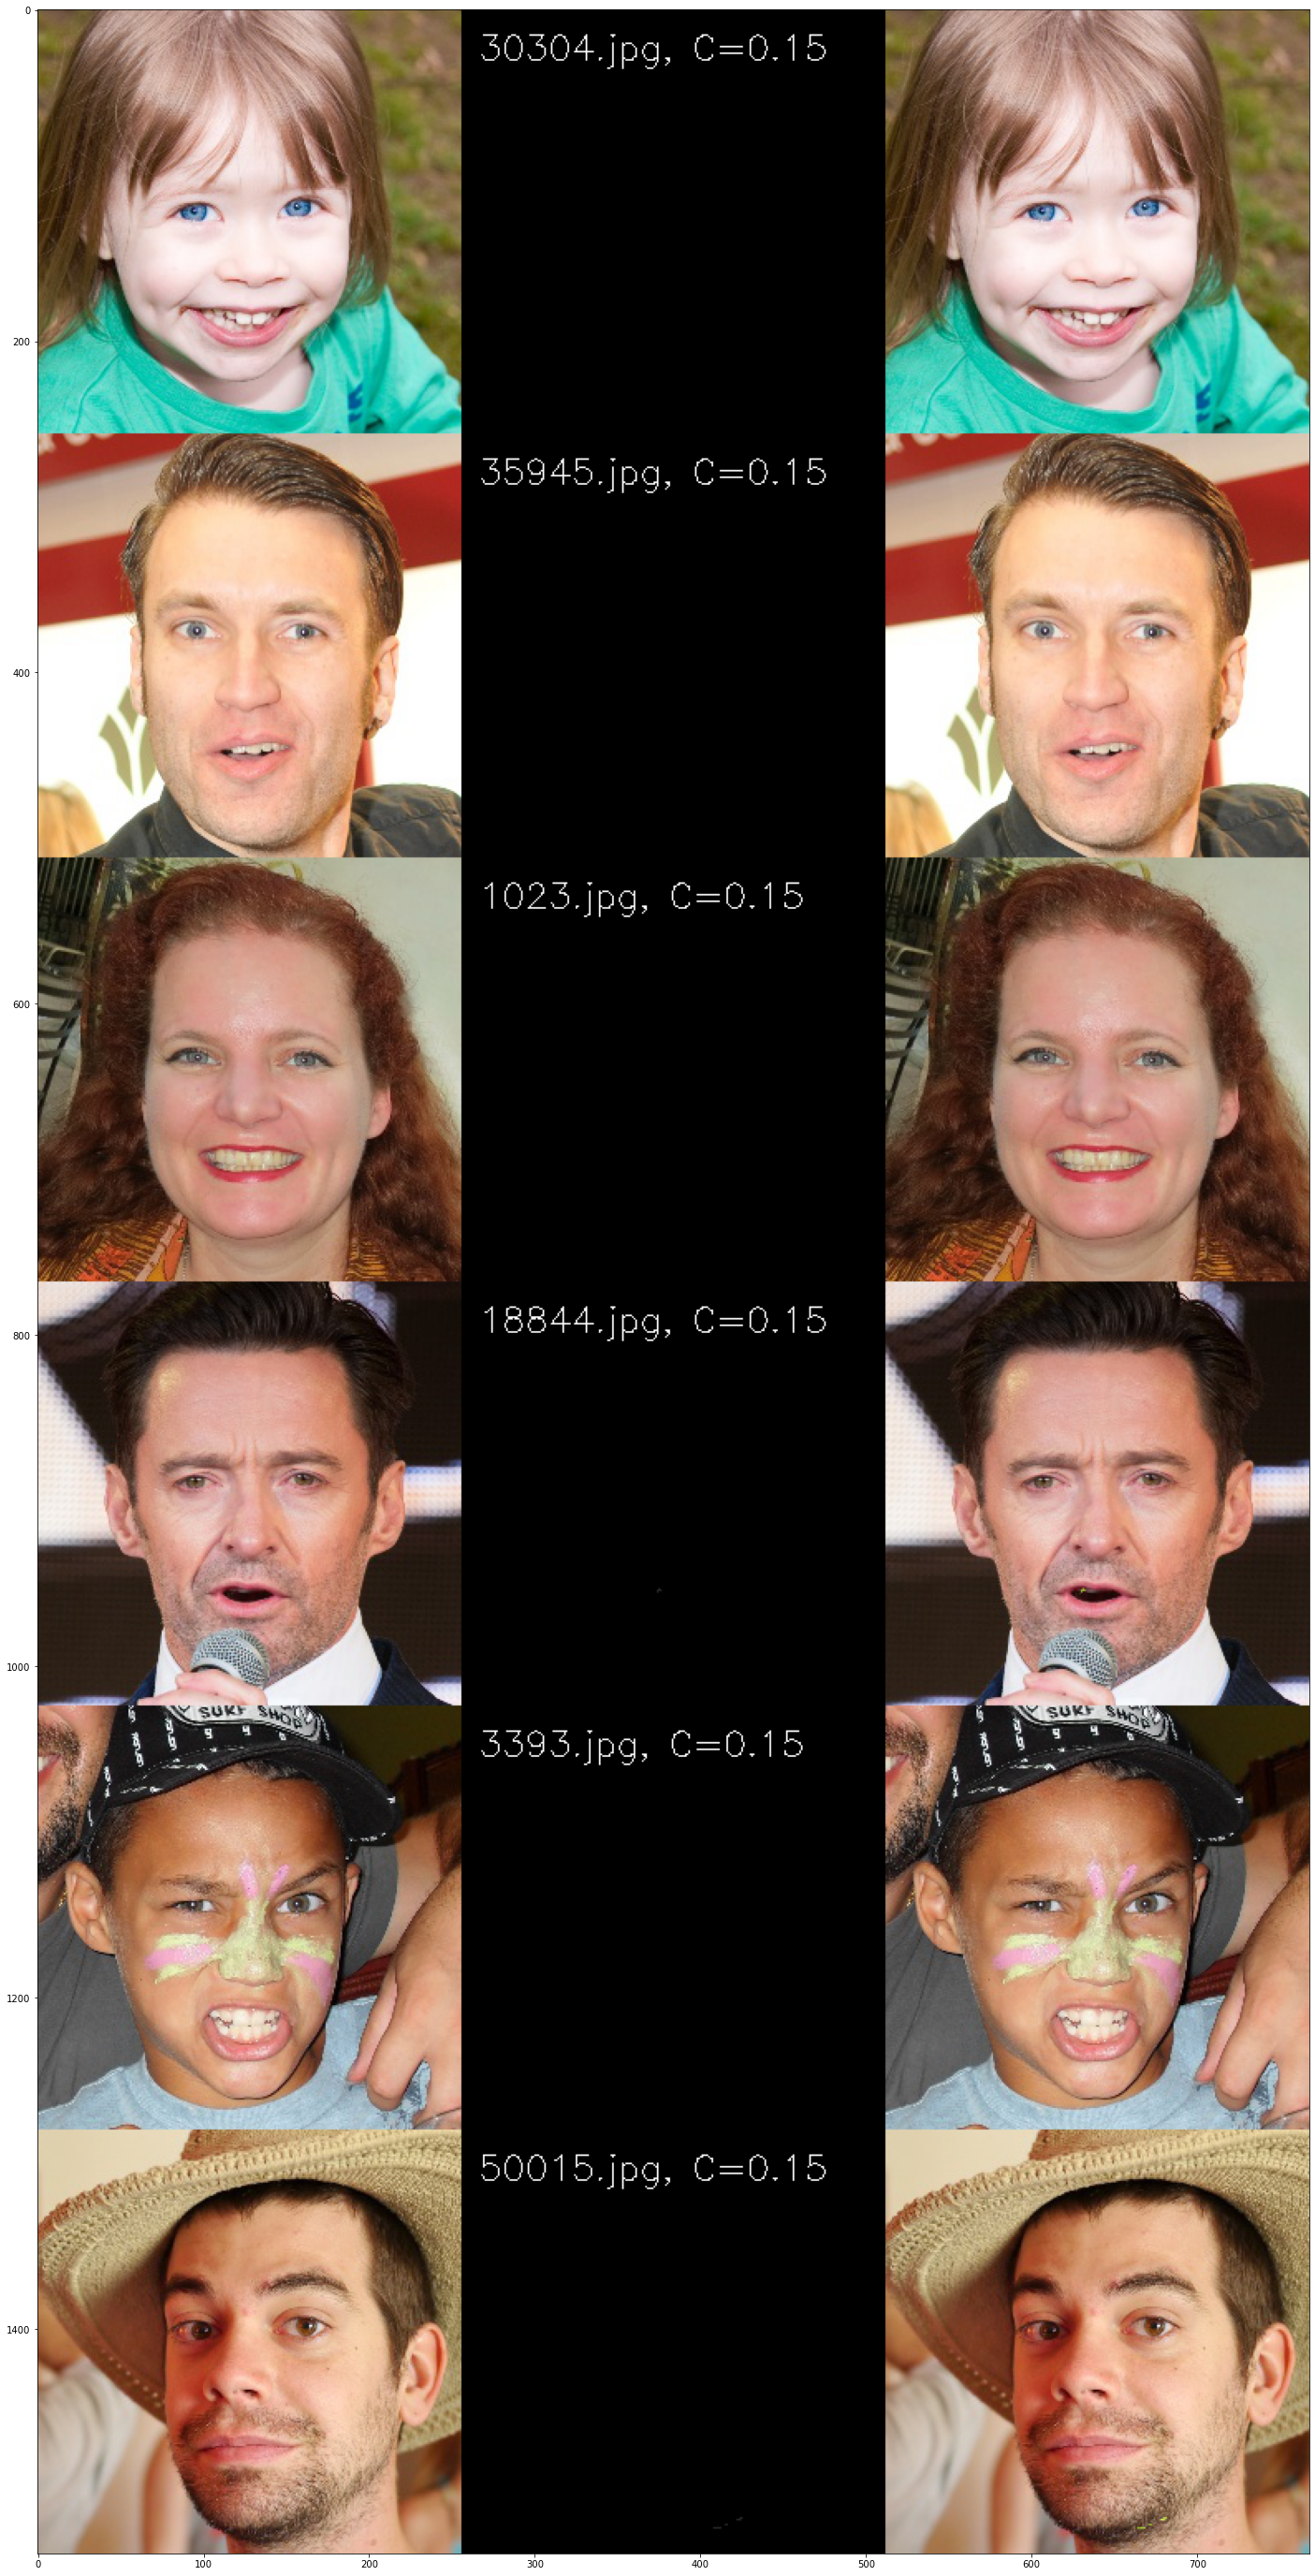

In [ ]:
# Visualize c-values < input threshold
mean = np.mean(c_sorted_norm['c_val'])
sd = np.std(c_sorted_norm['c_val'])
print("Mean: ", mean)
print("Std: ", sd)

def vis(c_vis, n, n_rows=8):
    img_top_n = [read_image(f'{img_p}/{c_vis.iloc[i, 0]}').permute(1, 2, 0).cpu().numpy() for i in range(n)]
    cval_top_n = c_vis['c_val'].values[:n]
    name_top_n = c_vis['image_name'].values[:n]
    # ray_top_n = [read_image(f"{ray_p}/{c_vis.iloc[i, 0].replace('.jpg', '.png')}").permute(1, 2, 0).cpu().numpy() for i in range(n)]
    sd_top_n = [(np.load(f"{shadow_diff_path}/{c_vis.iloc[i, 0].replace('.jpg', '.npy')}").repeat(3, -1) * 255).astype(np.uint8) for i in range(n)]
    # print(sd_top_n[0].shape)
    # print(sd_top_n[0].min(), sd_top_n[0].max())
    # assert False

    print(np.max(sd_top_n[0]), np.min(sd_top_n[0]))
    print(np.unique(sd_top_n[0]))
        
    # Overlay shadow diff on top of image
    # Change sd_top_n to RGB with greeny color
    # sd_top_n_hl = [cv2.applyColorMap(sd_top_n[i], cv2.COLORMAP_JET) * sd_top_n[i] for i in range(n)]
    
    mask_sd = [((sd_top_n[i] > 0)*255).astype(np.uint8) for i in range(n)]
    for i, r in enumerate(sd_top_n):
        cv2.putText(r, f"{name_top_n[i]}, C={cval_top_n[i]:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
    # sd_top_n_hl = [cv2.applyColorMap(sd_top_n[i], cv2.COLORMAP_JET) * sd_top_n[i] for i in range(n)]
    # overlay_img = [cv2.addWeighted(img_top_n[i], 1, sd_top_n_hl[i], 0.5, 0) for i in range(n)]
    sd_top_n_hl = [cv2.applyColorMap(mask_sd[i], cv2.COLORMAP_WINTER) * (mask_sd[i]==255) for i in range(n)]
    overlay_img = [cv2.addWeighted(img_top_n[i], 1, sd_top_n_hl[i], 0.5, 0) for i in range(n)]
        


    # # Combined n list into 1 list
    vis_top_n = sum([[img_top_n[i], sd_top_n[i], overlay_img[i]] for i in range(n)], [])

    plt.figure(figsize=(50, 50))
    plt.imshow(create_image_grid(vis_top_n, n_rows=n_rows))


# c_vis = c_sorted_norm[(c_sorted_norm['c_val'] <= mean+1*sd) & (c_sorted_norm['c_val'] >= mean-1*sd)]

n_img = []
# for lb, ub in [(0.0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9)]:
# for lb, ub in [(0.0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9)]:
# for lb, ub in [(0.2890994269391828, 0.2891994269391828)]:
# for lb, ub in [(0.15416536941904097, 0.154265369419040)]:
# for lb, ub in [(0.21441721642366304, 0.21441721642366305)]:
for lb, ub in [(0.18227753316735532, 0.18227753316735533)]:
    # c_vis = c_sorted_norm[(c_sorted_norm['c_val'] <= 0.5) & (c_sorted_norm['c_val'] >= 0.4)]
    c_vis = c_sorted_norm[(c_sorted_norm['c_val'] <= ub) & (c_sorted_norm['c_val'] >= lb)]
    print("[#] Proc: {:.2f} <= c_val <= {:.2f}".format(lb, ub))
    print("Length of c_vis: ", len(c_vis))
    n_img.append(len(c_vis))
    n = 6
    n = min(n, len(c_vis))
    vis(c_vis, n, n_rows=n//1)
    plt.savefig(f"./vis_{lb}_{ub}.png")


# sns.displot(n_img, kde=True, bins=len(n_img), density=True)

# Generate shadow area visualization

In [9]:
# Visualize c-values < input threshold
mean = np.mean(c_sorted_norm['c_val'])
sd = np.std(c_sorted_norm['c_val'])
print("Mean: ", mean)
print("Std: ", sd)

def save_vis(c_vis, i):
    # img_top_n = [read_image(f'{img_p}/{c_vis.iloc[i, 0]}').permute(1, 2, 0).cpu().numpy() for i in range(n)]
    # cval_top_n = c_vis['c_val'].values[:n]
    # name_top_n = c_vis['image_name'].values[:n]

    img = read_image(f'{img_p}/{c_vis.iloc[i, 0]}').permute(1, 2, 0).cpu().numpy()
    cval = c_vis['c_val'].values[i]
    name = c_vis['image_name'].values[i]
    # ray_top_n = [read_image(f"{ray_p}/{c_vis.iloc[i, 0].replace('.jpg', '.png')}").permute(1, 2, 0).cpu().numpy() for i in range(n)]
    # sd_top_n = [(np.load(f"{shadow_diff_path}/{c_vis.iloc[i, 0].replace('.jpg', '.npy')}").repeat(3, -1) * 255).astype(np.uint8) for i in range(n)]
    sd = (np.load(f"{shadow_diff_path}/{c_vis.iloc[i, 0].replace('.jpg', '.npy')}").repeat(3, -1) * 255).astype(np.uint8)
    # print(sd_top_n[0].shape)
    # print(sd_top_n[0].min(), sd_top_n[0].max())
    # assert False
        
    # Overlay shadow diff on top of image
    # Change sd_top_n to RGB with greeny color
    # sd_top_n_hl = [cv2.applyColorMap(sd_top_n[i], cv2.COLORMAP_JET) * sd_top_n[i] for i in range(n)]
    
    # mask_sd = [((sd_top_n[i] > 0)*255).astype(np.uint8) for i in range(n)]
    mask_sd = ((sd > 0)*255).astype(np.uint8)
    # for i, r in enumerate(sd_top_n):
    #     cv2.putText(r, f"{name_top_n[i]}, C={cval_top_n[i]:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)
    cv2.putText(sd, f"{name}, C={cval:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 1)

    # sd_top_n_hl = [cv2.applyColorMap(sd_top_n[i], cv2.COLORMAP_JET) * sd_top_n[i] for i in range(n)]
    # overlay_img = [cv2.addWeighted(img_top_n[i], 1, sd_top_n_hl[i], 0.5, 0) for i in range(n)]
    # sd_top_n_hl = [cv2.applyColorMap(mask_sd[i], cv2.COLORMAP_WINTER) * (mask_sd[i]==255) for i in range(n)]
    # overlay_img = [cv2.addWeighted(img_top_n[i], 1, sd_top_n_hl[i], 0.5, 0) for i in range(n)]

    sd_hl = cv2.applyColorMap(mask_sd, cv2.COLORMAP_WINTER) * (mask_sd==255)
    overlay_img = cv2.addWeighted(img, 1, sd_hl, 0.5, 0)

    out_img = np.concatenate([img, sd, overlay_img], axis=1)
    Image.fromarray(out_img).save(f"/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff_with_weight_simplified/vis/{set_}/{name.split('.')[0]}.png")
    # Image.write(f"./shadow_area/vis_shadow.png")

os.makedirs(f'/data/mint/DPM_Dataset/ffhq_256_with_anno/shadow_diff_with_weight_simplified/vis/{set_}/', exist_ok=True)

for i in tqdm.tqdm(range(len(c_sorted_norm))):
    # if i == 10: break
    save_vis(c_sorted_norm, i)
# sns.displot(n_img, kde=True, bins=len(n_img), density=True)

Mean:  0.34956119320024237
Std:  0.1314823457058355


 49%|████▉     | 29342/60000 [38:50<40:35, 12.59it/s]  


OSError: [Errno 28] No space left on device